Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.3) 영화 평점 예측하기

### 바로가기

- [1. MovieLens 데이터 살펴보기](#1.-MovieLens-데이터-살펴보기)
    - [MovieLens 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
        - 분석할 영화의 정보 탐색하기
        - 분석할 유저의 정보 탐색하기
        - 평점 데이터의 정보 탐색하기
- [2. 수학적 기법을 활용한 평점 예측](#2.-수학적-기법을-활용한-평점-예측)
    - [SVD를 활용한 빈칸 채우기]
    - [아직 평가하지 않은 영화의 점수 예측하기]
- [3. 예측 결과 분석 및 활용하기](#3.-예측-결과-분석-및-활용하기)
    - [예측 모델의 평가 방법]
    - [20대가 좋아할만한 영화를 예측해보자]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1. MovieLens 데이터 살펴보기

### [MovieLens 데이터셋의 기본 정보]

In [2]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [3]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


-----

### [탐색적 데이터 분석]

##### 분석할 영화의 정보 탐색하기

In [7]:
# 영화의 개수
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

total number of movie in data : 3883


-----

In [8]:
# 연도별 탐색 (Top 10)
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

-----

In [9]:
# 연대별 탐색
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


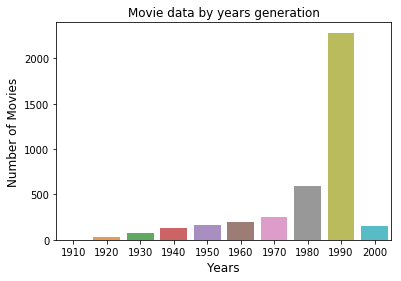

In [10]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

-----

In [11]:
# 가장 많이 사용된 장르의 조합 (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

-----

In [12]:
# 가장 많이 등장한 장르의 속성
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


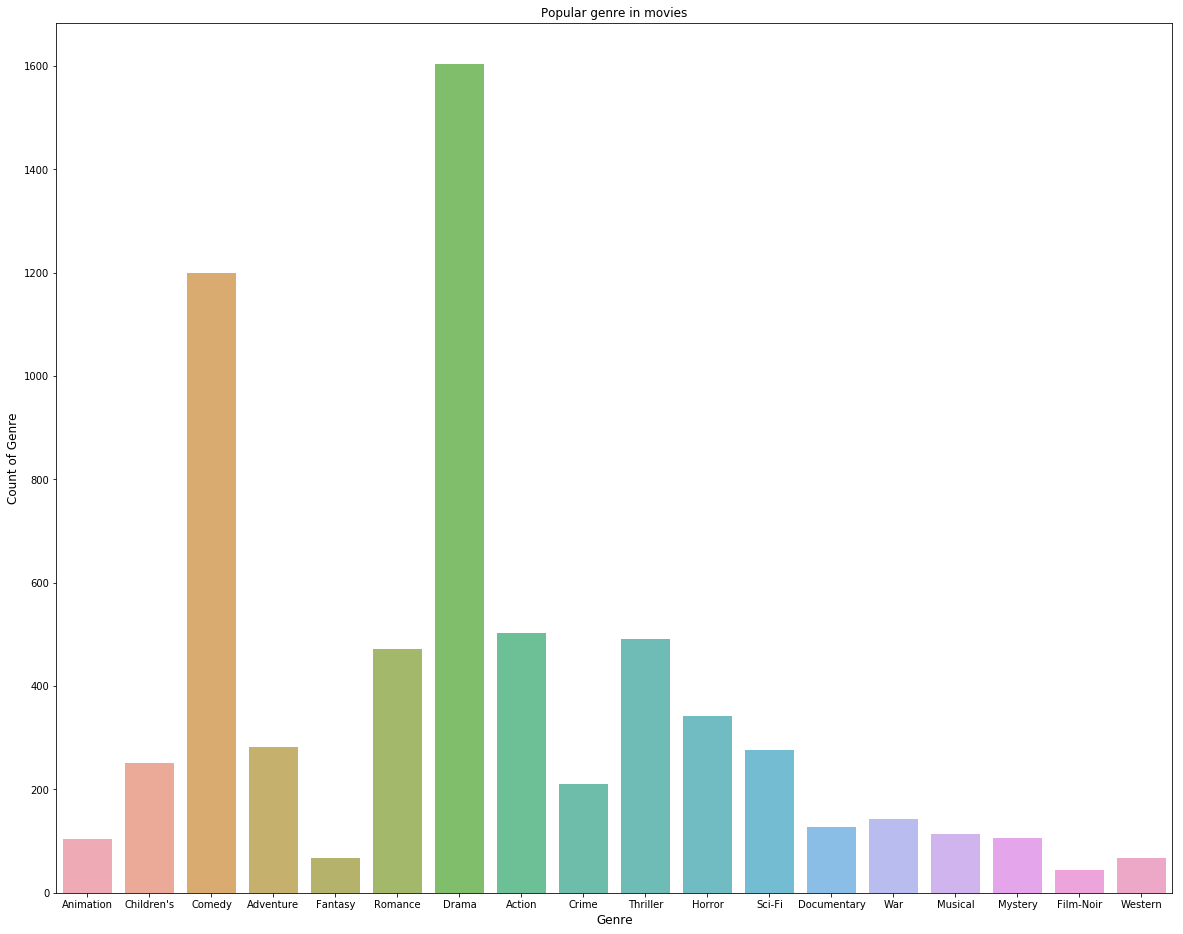

In [13]:
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

##### 분석할 유저의 정보 탐색하기

In [14]:
# 유저의 수 탐색
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


-----

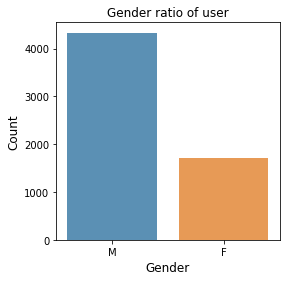

In [15]:
# 유저의 성별 탐색
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

-----

In [16]:
# 유저의 연령대 탐색
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [17]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

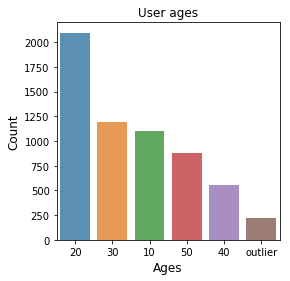

In [18]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

-----

##### 평점 데이터의 정보 탐색하기

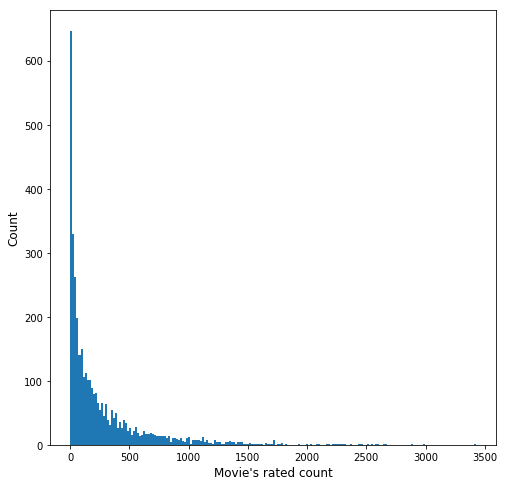

In [19]:
# 영화들이 평가받은 횟수 탐색
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [20]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


-----

In [21]:
# 영화별 평균 평점 탐색
merged_data = rating_data.merge(movie_data, on=['movie_id'], how='left')
movie_grouped_rating_info = merged_data.groupby('movie_id')['rating'].agg({'rated_count':'count', 'rating_mean':'mean'})

In [22]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


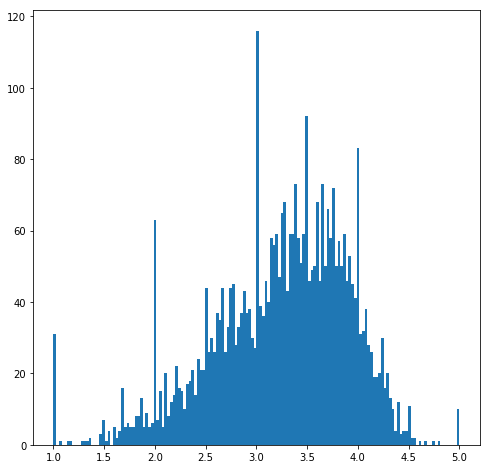

In [23]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

-----

In [24]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화
movie_grouped_rating_info[movie_grouped_rating_info['rated_count'] > 100].nlargest(10, 'rating_mean')

,rated_count,rating_mean
movie_id,,
2019,628,4.560510
318,2227,4.554558
858,2223,4.524966
745,657,4.520548
50,1783,4.517106
527,2304,4.510417
1148,882,4.507937
922,470,4.491489
1198,2514,4.477725


-----

In [25]:
# 유저별 영화 평가 탐색
merged_data = rating_data.merge(user_data, on=['user_id'], how='left')
user_grouped_rating_info = merged_data.groupby('user_id')['rating'].agg({'rated_count':'count', 
                                                                         'rating_mean':'mean', 
                                                                         'rating_std':'std'})

In [26]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


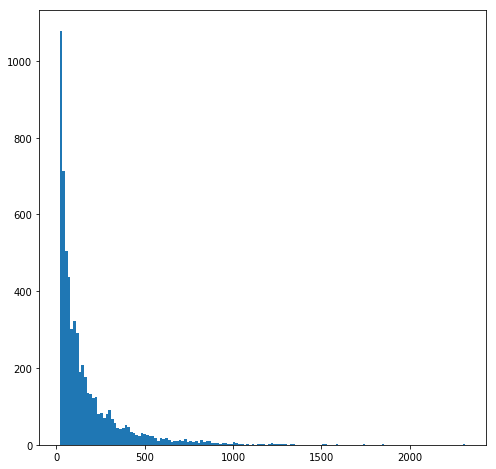

In [27]:
# 유저별로 평가한 영화 개수의 분포
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

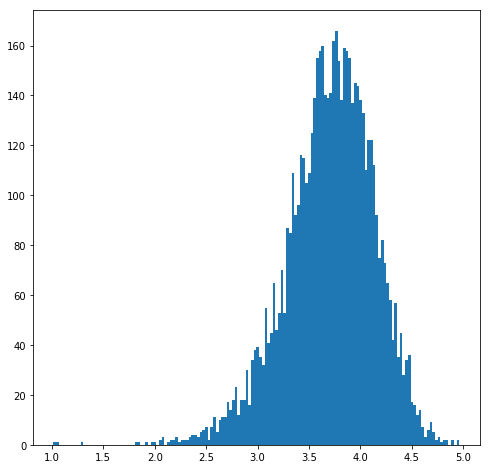

In [28]:
# 유저별로 평가한 영화 점수 평균의 분포
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

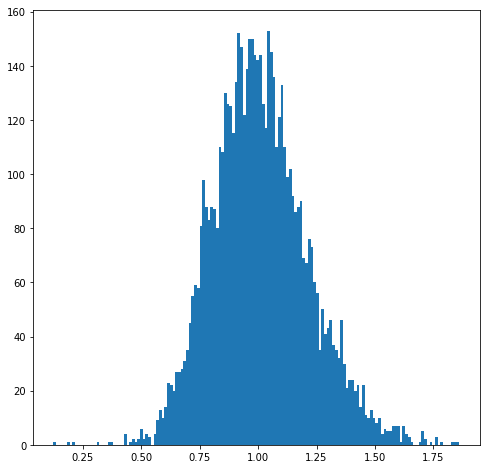

In [29]:
# 유저별로 평가한 영화 점수 편차의 분포
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

-----

In [30]:
# user-movie 형태의 테이블로 살펴보기
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [31]:
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

-----

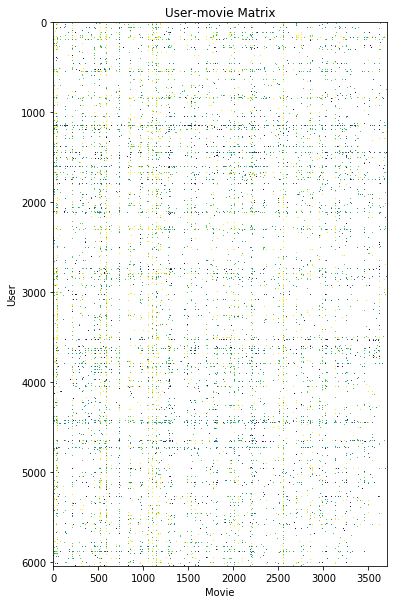

In [32]:
# user-movie 테이블 시각화
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

-----

# 2. 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

##### 빈칸을 포함한 user-item 행렬 생성

In [33]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [34]:
# 데이터 프레임 생성
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [35]:
# 데이터 프레임을 행렬로 변환하여 확인
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

-----

##### SVD를 이용한 빈칸 채우기 학습

In [36]:
# SVD 사용을 위한 데이터셋 생성
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [37]:
# SVD 학습
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [38]:
# 학습한 모델을 기반으로 점수 예측
test_data = [('c', 1, 0.0), ('c', 2, 5.0), ('c', 3, 0.0)]
predictions = model.test(test_data)
print(predictions)
print("----------------------------------------")

[Prediction(uid='c', iid=1, r_ui=0.0, est=3.6221545085617817, details={'was_impossible': False}), Prediction(uid='c', iid=2, r_ui=5.0, est=3.9313579304208814, details={'was_impossible': False}), Prediction(uid='c', iid=3, r_ui=0.0, est=3.8018392397560756, details={'was_impossible': False})]
----------------------------------------


In [39]:
def get_user_ratings(predictions, user_id):
    user_rating_dict = {}
    for uid, iid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            user_rating_dict[iid] = predicted_rating
    return user_rating_dict

user_rating_dict = get_user_ratings(predictions, user_id='c')

for key, value in user_rating_dict.items():
    print("Item id", key, "|", "rating :", value)

Item id 1 | rating : 3.6221545085617817
Item id 2 | rating : 3.9313579304208814
Item id 3 | rating : 3.8018392397560756


-----

### [아직 평가하지 않은 영화의 점수 예측하기]

##### 평가하지 않은 영화의 점수를 예측할 타겟 유저 선정

In [40]:
# user_id가 1인 유저의 영화 평가 데이터
target_user_id = 1
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [41]:
# 유저가 평가한 영화 히스토리
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{1193: 5, 661: 3, 914: 3, 3408: 4, 2355: 5, 1197: 3, 1287: 5, 2804: 5, 594: 4, 919: 4, 595: 5, 938: 4, 2398: 4, 2918: 4, 1035: 5, 2791: 4, 2687: 3, 2018: 4, 3105: 5, 2797: 4, 2321: 3, 720: 3, 1270: 5, 527: 5, 2340: 3, 48: 5, 1097: 4, 1721: 4, 1545: 4, 745: 3, 2294: 4, 3186: 4, 1566: 4, 588: 4, 1907: 4, 783: 4, 1836: 5, 1022: 5, 2762: 4, 150: 5, 1: 5, 1961: 5, 1962: 4, 2692: 4, 260: 4, 1028: 5, 1029: 5, 1207: 4, 2028: 5, 531: 4, 3114: 4, 608: 4, 1246: 4}


-----

##### MovieLens 데이터에 SVD 적용하기

In [42]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 85.21 seconds


-----

##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [43]:
# 타겟 유저 정보를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
    test_data.append((target_user_id, movie_id, rating))

In [44]:
# 타겟 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [45]:
# 예측된 점수 중, Top 10 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1),reverse=True)[:10]

In [46]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(3554, 5),
 (1997, 4.992611330065552),
 (1012, 4.935174653353155),
 (593, 4.914108100433583),
 (2175, 4.889755630153601),
 (3101, 4.874303388586174),
 (1932, 4.841659451826398),
 (3365, 4.831724870665504),
 (1361, 4.800423799881194),
 (1387, 4.79454097983186)]

In [47]:
# 타이틀 정보로 출력하기 위한 준비
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [48]:
# 타이틀 정보로 출력한 Top 10
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Love and Basketball (2000) : 5
Exorcist, The (1973) : 4.992611330065552
Old Yeller (1957) : 4.935174653353155
Silence of the Lambs, The (1991) : 4.914108100433583
D�j� Vu (1997) : 4.889755630153601
Fatal Attraction (1987) : 4.874303388586174
Great Ziegfeld, The (1936) : 4.841659451826398
Searchers, The (1956) : 4.831724870665504
Paradise Lost: The Child Murders at Robin Hood Hills (1996) : 4.800423799881194
Jaws (1975) : 4.79454097983186


In [49]:
# 타겟 유저의 기존 선호 영화와 비교
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:30]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

One Flew Over the Cuckoo's Nest (1975) : 5
Bug's Life, A (1998) : 5
Ben-Hur (1959) : 5
Christmas Story, A (1983) : 5
Beauty and the Beast (1991) : 5
Sound of Music, The (1965) : 5
Awakenings (1990) : 5
Back to the Future (1985) : 5
Schindler's List (1993) : 5
Pocahontas (1995) : 5
Last Days of Disco, The (1998) : 5
Cinderella (1950) : 5
Apollo 13 (1995) : 5
Toy Story (1995) : 5
Rain Man (1988) : 5
Mary Poppins (1964) : 5
Dumbo (1941) : 5
Saving Private Ryan (1998) : 5
Erin Brockovich (2000) : 4
Snow White and the Seven Dwarfs (1937) : 4
Wizard of Oz, The (1939) : 4
Gigi (1958) : 4
Miracle on 34th Street (1947) : 4
Ferris Bueller's Day Off (1986) : 4
Airplane! (1980) : 4
Bambi (1942) : 4
Big (1988) : 4
E.T. the Extra-Terrestrial (1982) : 4
Titanic (1997) : 4
Ponette (1996) : 4


-----

# 3. 예측 결과 분석 및 활용하기

### [예측 모델의 평가 방법]

##### RMSE 계산하기

In [50]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# RMSE 계산
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 83.37 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8615


0.8615177855810775

-----

##### 하이퍼 파라미터 튜닝 예시

In [51]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 67.08 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8842
------------------------------------
training time of model: 69.85 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8772
------------------------------------
training time of model: 72.40 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8681
------------------------------------
training time of model: 74.58 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8632
------------------------------------
training time of model: 75.22 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8622
------------------------------------
training time of model: 78.56 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8594
------------------------------------
training time of model: 79.68 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8607
------------------------------------
training time of model: 82.18 seconds
RMSE of test data

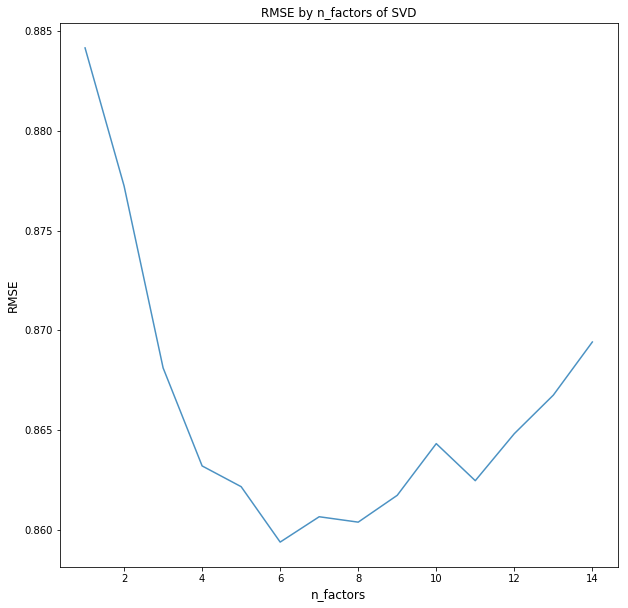

In [52]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

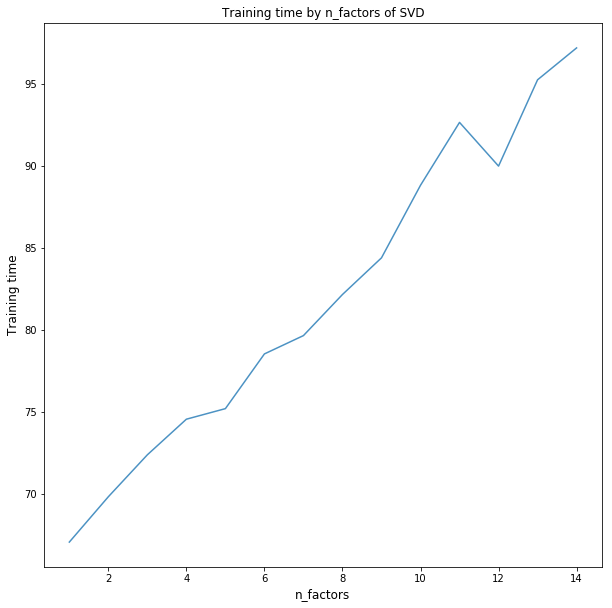

In [53]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

-----

##### 직접 테스트 해보기

- 테스트를 위한 데이터 분리

In [54]:
# 특정 시점을 기준으로 train, test 분리하기
train_rating_data = rating_data[rating_data['time'] < 975220939.00]
test_rating_data = rating_data[rating_data['time'] >= 975220939.00]
print(train_rating_data.shape)
print(test_rating_data.shape)

(750151, 4)
(250058, 4)


In [55]:
# 특정 시점 이전의 데이터로만 SVD 모델 학습
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

train_start = time.time()
model = SVD(n_factors=6,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 63.56 seconds


-----

- 테스트를 위한 타겟 유저 선정

In [56]:
# 타겟 유저 선정 - user_id 912 : 32, 11개의 train, test rating history
target_user_id = 912
target_user_data_train = train_rating_data[train_rating_data['user_id']==target_user_id]
print("user's train movie count", target_user_data_train.shape)

target_user_data_test = test_rating_data[test_rating_data['user_id']==target_user_id]
print("user's test movie count", target_user_data_test.shape)

user's train movie count (32, 4)
user's test movie count (11, 4)


In [57]:
# 유저가 평가한 영화 히스토리
target_user_movie_rating_dict_train = {}
target_user_movie_rating_dict_test = {}

for index, row in target_user_data_train.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict_train[movie_id] = row['rating']

for index, row in target_user_data_test.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict_test[movie_id] = row['rating']

In [58]:
print(target_user_movie_rating_dict_train)

{2997: 5, 1292: 4, 1295: 3, 2243: 5, 919: 3, 2427: 2, 2289: 4, 986: 3, 1673: 5, 260: 3, 3481: 4, 3809: 3, 608: 5, 3844: 3, 492: 4, 1193: 4, 1394: 5, 2352: 4, 3160: 4, 3317: 5, 3189: 3, 1732: 4, 125: 4, 2700: 3, 3362: 4, 3545: 4, 1961: 3, 3566: 4, 356: 2, 3578: 4, 2797: 4, 1207: 5}


In [59]:
print(target_user_movie_rating_dict_test)

{1449: 5, 2804: 5, 3624: 2, 2872: 3, 2100: 3, 2174: 3, 2599: 5, 3751: 3, 1073: 3, 2968: 3, 1097: 3}


-----

- 선정된 타겟 유저의 정보로 테스트 실시

In [60]:
# 타겟 유저 정보를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict_train:
        rating = target_user_movie_rating_dict_train[movie_id]
    test_data.append((target_user_id, movie_id, rating))

In [61]:
# 타겟 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict_test)

In [62]:
target_user_movie_predict_dict

{1073: 3.779716158819765,
 1097: 3.4994792334545615,
 1449: 4.135936389526549,
 2100: 2.9824548662617647,
 2174: 3.4321446375067293,
 2599: 4.315730682187505,
 2804: 4.075144590931938,
 2872: 3.5617264079327673,
 2968: 3.6471393029064303,
 3624: 3.156112666322828,
 3751: 3.848907578259098}

In [63]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict_test[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append("movie" + str(idx))

movie 1 : Willy Wonka and the Chocolate Factory (1971) - 3 / 3.78
movie 2 : E.T. the Extra-Terrestrial (1982) - 3 / 3.5
movie 3 : Waiting for Guffman (1996) - 5 / 4.14
movie 4 : Splash (1984) - 3 / 2.98
movie 5 : Beetlejuice (1988) - 3 / 3.43
movie 6 : Election (1999) - 5 / 4.32
movie 7 : Christmas Story, A (1983) - 5 / 4.08
movie 8 : Excalibur (1981) - 3 / 3.56
movie 9 : Time Bandits (1981) - 3 / 3.65
movie 10 : Shanghai Noon (2000) - 2 / 3.16
movie 11 : Chicken Run (2000) - 3 / 3.85


-----

- 결과의 시각화

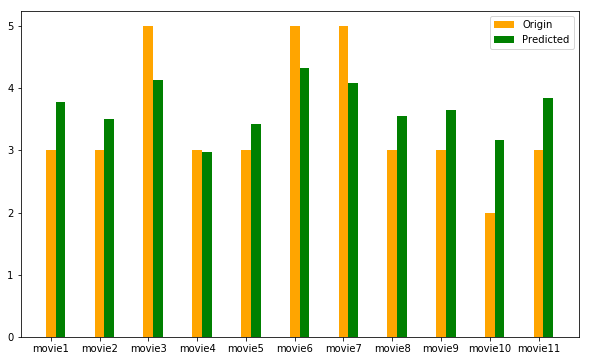

In [64]:
origin = origin_rating_list
predicted = predicted_rating_list
 
# create plot
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')

plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

-----

### [20대가 좋아할만한 영화를 예측해보자]

##### 20대 유저 리스트 선정

In [65]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

-----

##### 모델 학습

In [66]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 학습
train_start = time.time()
model = SVD(n_factors=6,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 85.52 seconds


-----

- 평가하지 않은 user-movie rating들에 대한 예측값을 통해, 20대가 좋아할 것 같은 영화 리스트 선정

In [67]:
# 평가하지 않은 user-movie rating들에 대한 예측값
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# calculate mean
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 660.12 seconds


In [68]:
# 선정된 리스트 출력
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.584415667329096
title: Shawshank Redemption, The (1994) | rating: 4.551474300830981
title: Schindler's List (1993) | rating: 4.452785447299211
title: Gate of Heavenly Peace, The (1995) | rating: 4.440557809855701
title: Usual Suspects, The (1995) | rating: 4.4128020897965445
title: Godfather, The (1972) | rating: 4.411540280808044
title: For All Mankind (1989) | rating: 4.406205023456119
title: Lamerica (1994) | rating: 4.402330259814312
title: Apple, The (Sib) (1998) | rating: 4.398594144641172
title: One Flew Over the Cuckoo's Nest (1975) | rating: 4.366778927059318
